In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import scale
from scipy.spatial.distance import cosine
from simhash import Simhash
import re
%matplotlib inline

In [2]:
def record(pred):
    df = pd.read_csv('history.csv', header=None)
    df[len(df.columns)] = pred
    df.to_csv('history.csv', header=None, index=False)

In [3]:
prefix = "4step_"
df = pd.read_csv(prefix+"sample.csv")
X = np.squeeze(np.dstack([df['head'].values, df['tail'].values]))
Y = df['label'].values
print(X.shape, Y.shape)

(169941, 2) (169941,)


In [4]:
with open("nodeMeta.pkl", 'rb') as f:
    nodeMeta = pickle.load(f)

In [5]:
test_x = []
for fromId, toId in np.loadtxt('t3-test.txt'):
    test_x.append((fromId,  toId))
test_x = np.array(test_x).astype('int64')

In [6]:
prefix = "4step_"
with open(prefix+'feat.pkl', 'rb') as f:
    feat = pickle.load(f)
with open(prefix+'test_f.pkl', 'rb') as f:
    test_f = pickle.load(f)
print(feat.shape, test_f.shape)

In [7]:
split = int(len(X)*0.95)
train_f, val_f = feat[:split], feat[split:]
train_y, val_y = Y[:split], Y[split:]

In [8]:
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=10, nthread=3, objective='binary:logistic')
#model = XGBRegressor(n_estimators=600, learning_rate=0.1, max_depth=15, min_child_weight=11, gamma=0.2,
#                     objective='binary:logistic', colsample_bytree=0.6, subsample=0.9, reg_alpha=0.1, reg_lambda=1)

/home/dada/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
model.fit(train_f, train_y, early_stopping_rounds=5, eval_set=[(val_f, val_y)], verbose=True, eval_metric='rmse')

[0]	validation_0-rmse:0.477789
Will train until validation_0-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:0.458522
[2]	validation_0-rmse:0.442233
[3]	validation_0-rmse:0.428479
[4]	validation_0-rmse:0.416488
[5]	validation_0-rmse:0.40637
[6]	validation_0-rmse:0.397756
[7]	validation_0-rmse:0.390629
[8]	validation_0-rmse:0.384228
[9]	validation_0-rmse:0.379069
[10]	validation_0-rmse:0.37454
[11]	validation_0-rmse:0.370613
[12]	validation_0-rmse:0.367316
[13]	validation_0-rmse:0.364499
[14]	validation_0-rmse:0.362159
[15]	validation_0-rmse:0.359922
[16]	validation_0-rmse:0.358161
[17]	validation_0-rmse:0.356157
[18]	validation_0-rmse:0.354664
[19]	validation_0-rmse:0.353448
[20]	validation_0-rmse:0.352302
[21]	validation_0-rmse:0.351347
[22]	validation_0-rmse:0.350611
[23]	validation_0-rmse:0.349827
[24]	validation_0-rmse:0.349113
[25]	validation_0-rmse:0.348513
[26]	validation_0-rmse:0.348123
[27]	validation_0-rmse:0.347648
[28]	validation_0-rmse:0.347186
[29]	validation_0-rm

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=3,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [14]:
pred = model.predict(val_f)
p = pred.copy()
thres = 0.53
p[p > thres] = 1
p[p < thres] = 0
print(p.sum()/len(p))
print(metrics.roc_auc_score(val_y, p))
print(metrics.accuracy_score(val_y, p))
print(metrics.confusion_matrix(val_y, p).ravel(), 'tn, fp, fn, tp')
print(metrics.confusion_matrix(val_y, p).ravel()/metrics.confusion_matrix(p, val_y).ravel().sum(), 'tn, fp, fn, tp')

0.5068251353259591
0.8381821167732765
0.8381972228759709
[3495  679  696 3628] tn, fp, fn, tp
[0.41127324 0.07990115 0.08190162 0.42692398] tn, fp, fn, tp


0.5216231944281007
0.5004706989879972
0.8379618733819723


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1da205668>,
      dtype=object)

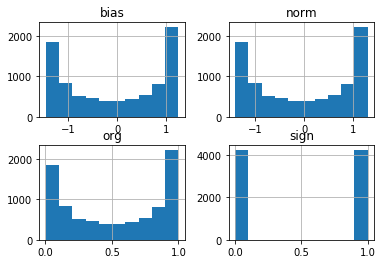

In [15]:
pred = model.predict(val_f)
df_tmp = pd.DataFrame()
p = pred.copy()
print(p.sum()/ len(p))
df_tmp['org'] = p

p = (p-p.mean())/p.std()
# normalize
df_tmp['norm'] = p

p += -0.05
# bias
df_tmp['bias'] = p

p = (np.sign(p)+1)/2
# sign
df_tmp['sign'] = p

print(p.sum() / len(p))
val_score = metrics.accuracy_score(val_y, p)
print(val_score)
df_tmp.hist()

0.5929343657250193
0.5026070215781171


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff1d9a09be0>,
      dtype=object)

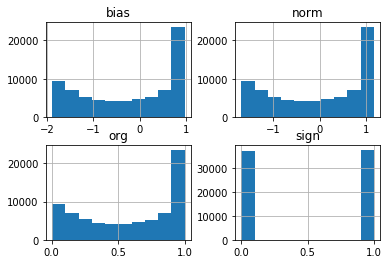

In [18]:
pred = model.predict(test_f)
df_tmp = pd.DataFrame()
p = pred.copy()
print(p.sum()/ len(p))
df_tmp['org'] = p

p = (p-p.mean())/p.std()
# normalize
df_tmp['norm'] = p

p += -0.2
# bias
df_tmp['bias'] = p

p = (np.sign(p)+1)/2
# sign
df_tmp['sign'] = p

print(p.sum() / len(p))
df_tmp.hist()

In [19]:
val_score = np.round(val_score, 3)
sum_ = np.round(p.sum() / len(p), 3)
Message = "add simhash, sample:4step val:{} sum:{}\nparams:{}".format(val_score, sum_, model.get_params())
print(Message)

add simhash, sample:4step val:0.838 sum:0.503
params:{'missing': None, 'reg_alpha': 0, 'n_estimators': 1000, 'colsample_bylevel': 1, 'silent': True, 'max_depth': 10, 'max_delta_step': 0, 'subsample': 1, 'reg_lambda': 1, 'colsample_bytree': 1, 'nthread': 3, 'learning_rate': 0.1, 'base_score': 0.5, 'objective': 'binary:logistic', 'min_child_weight': 1, 'seed': 0, 'scale_pos_weight': 1, 'gamma': 0}


In [24]:
from subprocess import call
import os
os.environ["KAGGLE_USERNAME"] = "b04902103"
os.environ["KAGGLE_KEY"] = "f53009dd66f3291b66dbc83d01cc1b8e"
with open('pred.txt', 'w') as f:
    for i in p.astype(int):
        print(i, file=f)
!python3 pred-txt-to-csv.py pred.txt
#kaggle competitions submit -c ntucsie-sdml2018-1-3 -f pred.txt.csv -m Message
call(["kaggle", "competitions", "submit", "-c", "ntucsie-sdml2018-1-3", "-f", "pred.txt.csv", "-m", Message])
!kaggle competitions leaderboard ntucsie-sdml2018-1-3 --show | head -n 10

 teamId  teamName                submissionDate       score    
-------  ----------------------  -------------------  -------  
2214321  b04902103_蔡昀達           2018-10-11 11:57:28  0.75480  
2191167  b05902002_李栢淵           2018-10-11 11:51:32  0.75314  
2201546  b04902011_張立暐           2018-10-11 09:42:36  0.73769  
2200428  r07921060_温明浩           2018-10-11 10:32:02  0.73157  
2154984  b04902016_曾奕青           2018-10-10 15:55:30  0.72929  
2154311  r06922086_林凡煒           2018-10-10 11:04:23  0.72052  
2162244  b04902113_陳柏叡           2018-10-10 13:57:55  0.71322  
2169477  r06922095_陳代穎           2018-10-11 11:46:17  0.71306  


In [25]:
record(p)

# To-Do

* concat pv-dm pd-dbow
* rnn auto-encoder
* node embedding
* new sample distribution